<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-03-15 21:31:33--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2022-03-15 21:31:33 (14.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



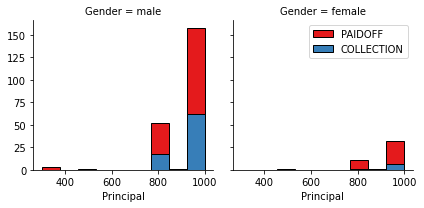

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

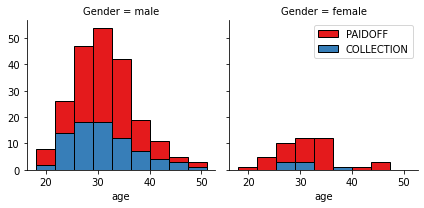

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


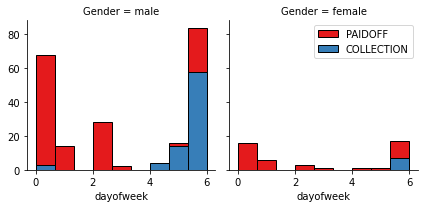

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#create training, testing data sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print('Train set:', X_train.shape, Y_train.shape)
print('Test set:', X_test.shape, Y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
#import 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#train model and look for the most accurate K level by runing a loop to fit up to K=15
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros(Ks-1)
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,Y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(Y_test,yhat)
    std_acc[n-1] = np.std(yhat==Y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.65714286, 0.64285714, 0.64285714, 0.6       , 0.65714286,
       0.65714286, 0.72857143, 0.71428571, 0.71428571])

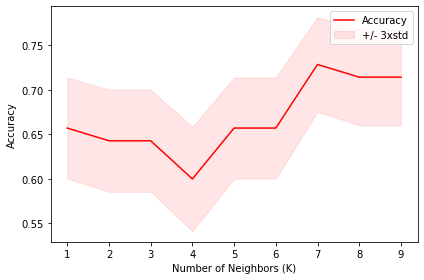

The best accuracy was 0.7285714285714285 when k= 7


In [22]:
#plot accuracy for range of neighbors
plt.plot(range(1,Ks),mean_acc,'r')
plt.fill_between(range(1,Ks),mean_acc-1*std_acc,mean_acc+1*std_acc, alpha=0.10,color="red")
plt.legend(('Accuracy','+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print("The best accuracy was", mean_acc.max(), "when k=", mean_acc.argmax()+1)
neigh=KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train,Y_train)

# Decision Tree


In [23]:
#install necessary libraries
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from sklearn import tree
import matplotlib.image as mpimg
!pip install graphviz
!pip install pydotplus
import graphviz
import pydotplus

# initialize model
modeltree = DecisionTreeClassifier(criterion="entropy")
modeltree.fit(X_train,Y_train)

#predict from test set
predictiontree = modeltree.predict(X_test)
print("This is the predicted result:",predictiontree[0:5])
print("This is the actual test result:",Y_test[0:5])

     |████████████████████████████████| 278 kB 24.6 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=6d920b8972a6e9f28dfcd6b3bd640aed5c482c675cda2476c4017053d1819191
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/89/e5/de/6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus
This is the predicted result: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
This is the actual test result: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']


In [24]:
#evaluate decision tree accuracy
print("Decision Tree Accuracy:", metrics.accuracy_score(Y_test, predictiontree))

Decision Tree Accuracy: 0.6142857142857143


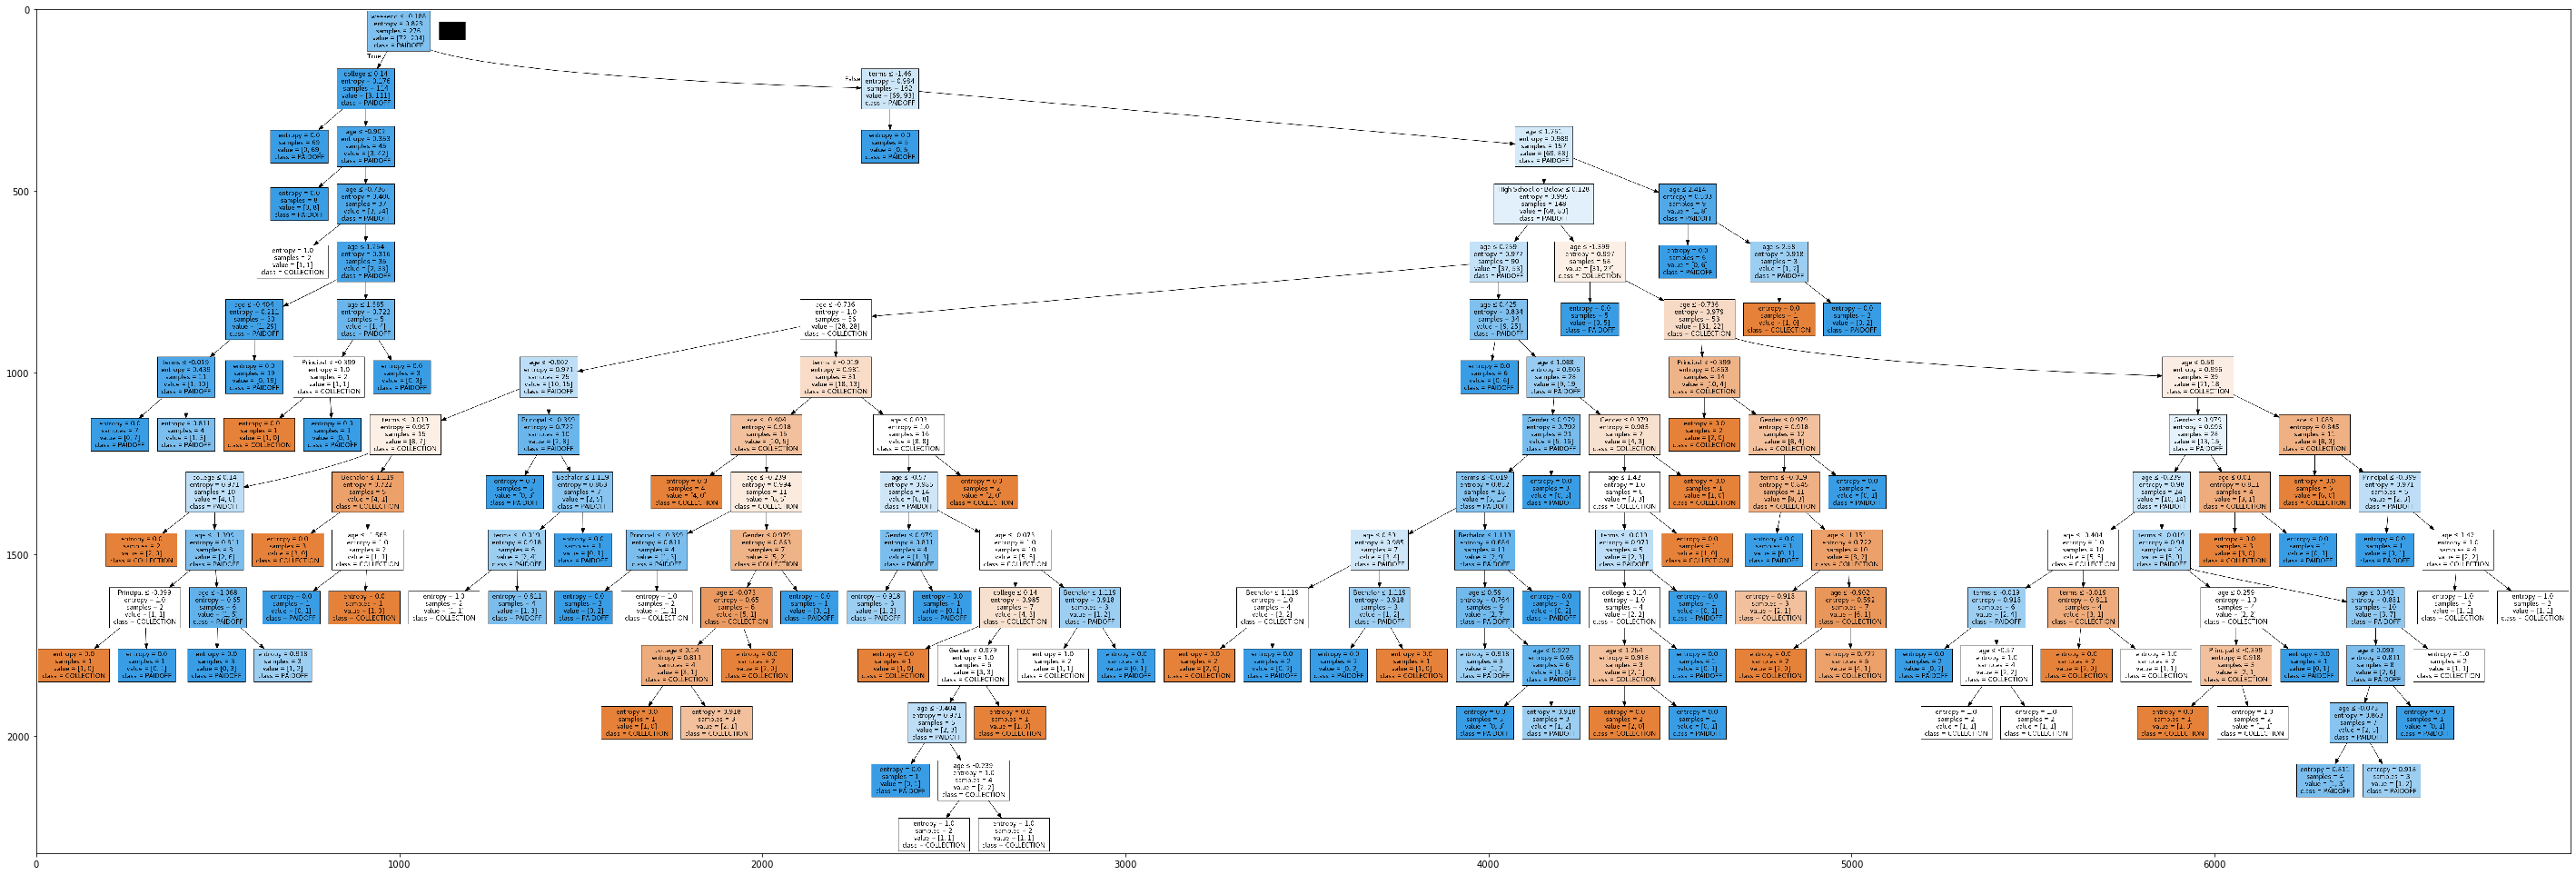

In [25]:
#visualize decision tree

dot_data=StringIO()
filename="tree.png"
featureNames=Feature.columns
out=tree.export_graphviz(modeltree,feature_names=featureNames,out_file=dot_data,class_names=np.unique(Y_train), filled=True, special_characters=True,rotate=False)  
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(50,100))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [26]:
#import libraries
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn import svm
#set up model
clf = svm.SVC(kernel="sigmoid")
clf.fit(X_train, Y_train)
clf

SVC(kernel='sigmoid')

In [27]:
#run prediction check
yhatsvm=clf.predict(X_test)
yhatsvm

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [28]:
#evaluation
from sklearn.metrics import f1_score
f1_score(Y_test,yhatsvm, average="weighted")

0.735934596804162

# Logistic Regression


In [29]:
#import libraries
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver="liblinear").fit(X_train,Y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [30]:
#run predictions
yhatLog = LR.predict(X_test)
yhatLog_prob = LR.predict_proba(X_test)
yhatLog_prob

array([[0.46112206, 0.53887794],
       [0.28982951, 0.71017049],
       [0.47385154, 0.52614846],
       [0.49580654, 0.50419346],
       [0.45022167, 0.54977833],
       [0.48211371, 0.51788629],
       [0.47038027, 0.52961973],
       [0.48769039, 0.51230961],
       [0.49058992, 0.50941008],
       [0.44584567, 0.55415433],
       [0.33386247, 0.66613753],
       [0.4809536 , 0.5190464 ],
       [0.49986238, 0.50013762],
       [0.31111625, 0.68888375],
       [0.49345784, 0.50654216],
       [0.51029619, 0.48970381],
       [0.46975525, 0.53024475],
       [0.4622238 , 0.5377762 ],
       [0.49058992, 0.50941008],
       [0.49812317, 0.50187683],
       [0.33077527, 0.66922473],
       [0.32566423, 0.67433577],
       [0.48247745, 0.51752255],
       [0.48363781, 0.51636219],
       [0.30715233, 0.69284767],
       [0.30679694, 0.69320306],
       [0.43422741, 0.56577259],
       [0.49986238, 0.50013762],
       [0.49754567, 0.50245433],
       [0.28506192, 0.71493808],
       [0.

In [31]:
#evaluate
from sklearn.metrics import log_loss
log_loss(Y_test,yhatLog_prob)

0.5539305986570232

# Model Evaluation using Test set


In [32]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-03-15 21:33:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-03-15 21:33:41 (60.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [34]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [35]:
#convert date and time
test_df['due_date']=pd.to_datetime(test_df['due_date'])
test_df['effective_date']=pd.to_datetime(test_df['effective_date'])
test_df['dayofweek']=test_df['effective_date'].dt.dayofweek
#weekend field evaluation
test_df['weekend']=test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
#education level dummies
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])],axis=1)
test_feature.drop(['Master or Above'], axis = 1, inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [36]:
#normalize test data
Test_X = preprocessing.StandardScaler().fit(test_feature).transform(test_feature)
Test_X[0:5]
Test_Y = test_df['loan_status'].values
Test_Y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [40]:
# K Nearest Neighbor (KNN)
test_yhatKNN=neigh.predict(Test_X)

# jaccard
KNN_Jaccard = jaccard_score(Test_Y, test_yhatKNN,average='weighted')
print("KNN - jaccard accuracy = " , KNN_Jaccard)

# f1_score
KNN_f1_score = f1_score(Test_Y, test_yhatKNN, average='weighted') 
print("KNN - f1 score accuracy = " , KNN_f1_score)

# Decision Tree
test_yhatDT = modeltree.predict(Test_X)

# jaccard
DTree_Jaccard = jaccard_score(Test_Y, test_yhatDT,average='weighted')
print("Decision Tree - jaccard accuracy = " , DTree_Jaccard)

# f1_score
DTree_f1_score = f1_score(Test_Y, test_yhatDT, average='weighted') 
print("Decision Tree - f1 score accuracy = " , DTree_f1_score)

# Support Vector Machine
test_yhatSVM = clf.predict(Test_X)

# jaccard
SVM_Jaccard = jaccard_score(Test_Y, test_yhatSVM,average='weighted')
print("Support Vector Machine - jaccard accuracy = " , SVM_Jaccard)

# f1_score
SVM_f1_score = f1_score(Test_Y, test_yhatSVM, average='weighted') 
print("Support Vector Machine - f1 score accuracy = " , SVM_f1_score)

#Logistic Regression
test_yhatLR = LR.predict(Test_X)
test_yhat_probLR = LR.predict_proba(Test_X)

# jaccard
LGR_Jaccard = jaccard_score(Test_Y, test_yhatLR,average='weighted')
print("Logistic Regression - jaccard accuracy = " , LGR_Jaccard)

# f1_score
LGR_f1_score = f1_score(Test_Y, test_yhatLR, average='weighted') 
print("Logistic Regression - f1 score accuracy = " , LGR_f1_score)

LGR_log_loss = log_loss(Test_Y, test_yhat_probLR)
print("Logistic Regression - log loss = " , LGR_log_loss)

# Print the Accuracy Report
#col_names = ['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']
algorithm_list = ['KNN', 'Decision Tree', 'SVM', 'LoisticRegression']
Jaccard_list = [KNN_Jaccard, DTree_Jaccard, SVM_Jaccard, LGR_Jaccard]
F1_score_list = [KNN_f1_score, DTree_f1_score, SVM_f1_score, LGR_f1_score]
LogLoss_list = ['NA', 'NA', 'NA', LGR_log_loss]

df = pd.DataFrame(list(zip(algorithm_list, Jaccard_list, F1_score_list, LogLoss_list)),
              columns=['Algorithm','Jaccard', 'F1-score', 'LogLoss'])

df.set_index('Algorithm', inplace = True)
df

KNN - jaccard accuracy =  0.5555555555555556
KNN - f1 score accuracy =  0.6860670194003526
Decision Tree - jaccard accuracy =  0.5868257038469804
Decision Tree - f1 score accuracy =  0.7252534070517485
Support Vector Machine - jaccard accuracy =  0.5416270971826528
Support Vector Machine - f1 score accuracy =  0.6579124579124579
Logistic Regression - jaccard accuracy =  0.5775681341719078
Logistic Regression - f1 score accuracy =  0.6717642373556352
Logistic Regression - log loss =  0.5706532248418953


,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.555556,0.686067,NA
Decision Tree,0.586826,0.725253,NA
SVM,0.541627,0.657912,NA
LoisticRegression,0.577568,0.671764,0.570653


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
